# ChromVAR  
  
This is a notebook to run chromvar on peaks derived from scATAC-seq stored in a Seurat object. This can be reworked to use peaks not entered into a Seurat object. ChromVAR needs 3 inputs. 1) A count matrix that is barcode x peak or sample x peak 2) GRanges identifying peaks and 3) motifs. Motifs can be a custom set, or downloaded from JASPAR. I have code in another location to pull and save JASPAR motifs into a usable format. JASPAR seems to update yearly. The motifs I pulled are all human.  

From here there are follow-up notebooks to compare cell types and disease states.

A reference for ChromVAR can be found here: https://greenleaflab.github.io/chromVAR/articles/Introduction.html

In [1]:
suppressMessages(library(chromVAR))
suppressMessages(library(motifmatchr))
suppressMessages(library(SummarizedExperiment))

library(Signac)
library(Seurat)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(patchwork)
library(readr)
library(stringr)
library(dplyr)
set.seed(1234)
library(ggplot2)

library(Matrix)
library(BiocParallel)
register(MulticoreParam(8))

#### Send to channel code
library(parallel)
library(qvalue)

Signac built for for SeuratObject v4 was just loaded with SeuratObject
v5; disabling v5 assays and validation routines, and ensuring assays
work in strict v3/v4 compatibility mode

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘sp’


The following object is masked from ‘package:IRanges’:

    %over%



Attaching package: ‘SeuratObject’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays


The following object is masked from ‘package:GenomicRanges’:

    intersect


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following object is masked from ‘package:IRanges’:

    intersect


The following object is masked from ‘package:S4Vectors’:

    intersect


The following object is masked from ‘package:BiocGenerics’:

    intersect


The following object is masked from ‘package:base’:

    intersect



Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedE

In [2]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.2 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/blas/libblas.so.3.9.0
LAPACK: /usr/lib/x86_64-linux-gnu/lapack/liblapack.so.3.9.0

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] qvalue_2.26.0                     BiocParallel_1.28.3              
 [3] Matrix_1.6-3                      ggplot2_3.5.0                    
 [5] dplyr_1.1.4                       stringr_1.5.1                    
 [7] readr_2.1.4         

In [4]:
#Load in Seurat ATAC object

atac <- readRDS('/nfs/lab/hmummey/multiomic_islet/intermediates/240308_28sample_combined.noDoublets.QCfilters.ATAC_peaks.FINAL_v2.w_union_peaks.rds')
DefaultAssay(atac) <- 'ATAC_CTpeaks'

atac

An object of class Seurat 
571775 features across 174819 samples within 4 assays 
Active assay: ATAC_CTpeaks (291821 features, 0 variable features)
 2 layers present: counts, data
 3 other assays present: RNA, ATAC, SCT
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

In [5]:
atac[['RNA']] <- NULL
atac[['SCT']] <- NULL
atac[['ATAC']] <- NULL

atac
gc()

An object of class Seurat 
291821 features across 174819 samples within 1 assay 
Active assay: ATAC_CTpeaks (291821 features, 0 variable features)
 2 layers present: counts, data
 7 dimensional reductions calculated: pca, harmony.rna, umap.rna, lsi, harmony.atac, umap.atac, umap.wnn

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,13078290,698.5,22796968,1217.5,17250390,921.3
Vcells,3889176942,29672.1,12799906380,97655.6,10790228178,82323.0


In [6]:
#Prep inputs for SummarizedExperiment

#Extract matrix from Seurat object
sc.data <- GetAssayData(atac,slot='data', assay="ATAC_CTpeaks")
sc.data.stored <- sc.data

# Extract peak locations and reformat into GRanges object
bed = str_split_fixed(rownames(sc.data), "\\-", 3) #This may need to be modified depending on your peak naming convention

gr= GRanges(seqnames = bed[,1], ranges = IRanges(start = as.numeric(bed[,2]), end = as.numeric(bed[,3])))

Warning message:
“The `slot` argument of `GetAssayData()` is deprecated as of SeuratObject 5.0.0.
ℹ Please use the `layer` argument instead.”


In [7]:
ptx <- readRDS("/nfs/lab/welison/islet_multiome/intermediates/PTX_data.RDS")

dim(ptx)
head(ptx)

[1] 38  6

,Record ID,# vials sent,Age,Sex,BMI,HbA1c
,<chr>,<int>,<int>,<chr>,<dbl>,<chr>
1,R119,1,27,Male,18.60000,no data
2,R207,2,50,Female,22.20000,no data
3,R216,2,38,Male,42.59259,5.6
4,R217,2,71,Female,35.53497,6.3
5,R218,1,73,Female,28.35938,5.9
6,R221,1,44,Male,30.48316,5.3


In [8]:
colnames(atac[[]])

[1] "orig.ident"                        "nCount_RNA"                       
 [3] "nFeature_RNA"                      "percent.mt"                       
 [5] "nCount_ATAC"                       "nFeature_ATAC"                    
 [7] "gex_raw_reads"                     "gex_mapped_reads"                 
 [9] "gex_conf_intergenic_reads"         "gex_conf_exonic_reads"            
[11] "gex_conf_intronic_reads"           "gex_conf_exonic_unique_reads"     
[13] "gex_conf_exonic_antisense_reads"   "gex_conf_exonic_dup_reads"        
[15] "gex_exonic_umis"                   "gex_conf_intronic_unique_reads"   
[17] "gex_conf_intronic_antisense_reads" "gex_conf_intronic_dup_reads"      
[19] "gex_intronic_umis"                 "gex_conf_txomic_unique_reads"     
[21] "gex_umis_count"                    "gex_genes_count"                  
[23] "atac_raw_reads"                    "atac_unmapped_reads"              
[25] "atac_lowmapq"                      "atac_dup_reads"                   
[27] "atac_chimeric_reads"               "atac_mitochondrial_reads"         
[29] "atac_fragments"                    "atac_TSS_fragments"               
[31] "atac_peak_region_fragments"        "atac_peak_region_cutsites"        
[33] "TSS.enrichment"                    "TSS.percentile"                   
[35] "nCount_SCT"                        "nFeature_SCT"                     
[37] "SCT.weight"                        "ATAC.weight"                      
[39] "wsnn_res.0.2"                      "seurat_clusters"                  
[41] "log_nCount_ATAC"                   "log_nCount_SCT"                   
[43] "log_nFeature_ATAC"                 "log_nFeature_SCT"                 
[45] "library"                           "keep_barcodes"                    
[47] "wsnn_res.0.25"                     "value"                            
[49] "assigned_celltype1"                "sub.cluster"                      
[51] "assigned_celltype2"                "above100"                         
[53] "major_celltypes"                   "subpop_celltypes"                 
[55] "nCount_ATAC_CTpeaks"               "nFeature_ATAC_CTpeaks"

In [9]:
#Use the matrix and GRanges to make a SummarizedExperiment to put into chromvar and add metadata

fragment.counts <- SummarizedExperiment(assays=list(counts=sc.data), rowRanges=gr)
fragment.counts.stored <- fragment.counts

# Adjust to include any columns from the Seurat object metadata you will use downstream. Easier to include more now.
metrics <- select(atac[[]], orig.ident, nCount_ATAC, nFeature_ATAC, TSS.enrichment, library, 
                  major_celltypes, subpop_celltypes, seurat_clusters) 

metrics_rownames <- rownames(metrics)
metrics <- left_join(metrics, ptx, by=join_by(library=='Record ID'))
rownames(metrics) <- metrics_rownames

if (length(rownames(metrics)) == sum(rownames(colData(fragment.counts)) == rownames(metrics))) {
    print("Success adding meta data")
    colData(fragment.counts) <- cbind(colData(fragment.counts), metrics[rownames(colData(fragment.counts)),])
} else {
    print("Failed to add meta data, check column names.")
}

fragment.counts <- addGCBias(fragment.counts, genome=BSgenome.Hsapiens.UCSC.hg38)
fragment.counts

[1] "Success adding meta data"


class: RangedSummarizedExperiment 
dim: 291821 174819 
metadata(0):
assays(1): counts
rownames(291821): chr1-1000073-1000373 chr1-100036794-100037094 ...
  chrY-9652738-9653038 chrY-9812080-9812380
rowData names(1): bias
colnames(174819): R207_AAACAGCCAAACGGGC-1 R207_AAACAGCCACAAAGAC-1 ...
  R364_TTTGTTGGTTAGGCGT-1 R364_TTTGTTGGTTCCGGCT-1
colData names(13): orig.ident nCount_ATAC ... BMI HbA1c

In [10]:
#Load in motifs
jaspar.motifs <- readRDS(file ='/nfs/lab/welison/multiome/chromvar/jaspar_2022_object.Rdata')
motif.ix <- matchMotifs(jaspar.motifs, fragment.counts, genome=BSgenome.Hsapiens.UCSC.hg38)

motif.ix

class: RangedSummarizedExperiment 
dim: 291821 692 
metadata(0):
assays(1): motifMatches
rownames(291821): chr1-1000073-1000373 chr1-100036794-100037094 ...
  chrY-9652738-9653038 chrY-9812080-9812380
rowData names(1): bias
colnames(692): MA0030.1_FOXF2 MA0031.1_FOXD1 ... MA1633.2_BACH1
  MA0597.2_THAP1
colData names(1): name

In [12]:
saveRDS(motif.ix, '/nfs/lab/welison/islet_multiome/intermediates/chromVAR/240322_WE_MotifMatches_Union_Peaks.RDS')

In [ ]:
# Run chromVAR
dev <- computeDeviations(object=fragment.counts, annotations=motif.ix)#, expectation=expected)#
head(dev)

In [13]:
saveRDS(dev, "/nfs/lab/welison/islet_multiome/intermediates/chromVAR/240322_WE_ChromVAR_Object_Union_Peaks.RDS")

# Collect details for downstream analysis

In [9]:
# Reload chromVAR object and motifs if picking up again
dev <- readRDS("/nfs/lab/welison/islet_multiome/intermediates/chromVAR/240322_WE_ChromVAR_Object_Union_Peaks.RDS")
jaspar.motifs <- readRDS(file ='/nfs/lab/welison/multiome/chromvar/jaspar_2022_object.Rdata')

In [14]:
dev
jaspar.motifs

class: chromVARDeviations 
dim: 692 174819 
metadata(0):
assays(2): deviations z
rownames(692): MA0030.1_FOXF2 MA0031.1_FOXD1 ... MA1633.2_BACH1
  MA0597.2_THAP1
rowData names(3): name fractionMatches fractionBackgroundOverlap
colnames(174819): R207_AAACAGCCAAACGGGC-1 R207_AAACAGCCACAAAGAC-1 ...
  R364_TTTGTTGGTTAGGCGT-1 R364_TTTGTTGGTTCCGGCT-1
colData names(13): orig.ident nCount_ATAC ... BMI HbA1c

PFMatrixList of length 692
names(692): MA0030.1_FOXF2 MA0031.1_FOXD1 ... MA1633.2_BACH1 MA0597.2_THAP1

In [15]:
#This is a cell by motif deviation score (aka accessibility) matrix
devtab = deviationScores(dev)
head(devtab)

,R207_AAACAGCCAAACGGGC-1,R207_AAACAGCCACAAAGAC-1,R207_AAACAGCCAGCAAGTG-1,R207_AAACAGCCAGTTATCG-1,R207_AAACAGCCATAATCCG-1,R207_AAACAGCCATACCCGG-1,R207_AAACAGCCATCGTTCT-1,R207_AAACAGCCATGGAGGC-1,R207_AAACAGCCATTGTGTG-1,R207_AAACATGCAAGCTTTG-1,⋯,R364_TTTGTGAAGGACCTTG-1,R364_TTTGTGAAGGCTGTGC-1,R364_TTTGTGAAGTGCACGC-1,R364_TTTGTGGCAAACTGTT-1,R364_TTTGTGGCAACCCTAA-1,R364_TTTGTGGCATCCAGGT-1,R364_TTTGTTGGTACTTAGG-1,R364_TTTGTTGGTCCTAATC-1,R364_TTTGTTGGTTAGGCGT-1,R364_TTTGTTGGTTCCGGCT-1
MA0030.1_FOXF2,1.4913928,-0.63687513,-0.7251524,-1.9781767,-1.06062116,0.6735748,0.4653425,-1.6394920,0.08687405,-1.61979764,⋯,0.96854476,-0.9464179,0.3128129,-0.4413636,-1.00060548,-1.1609709,1.2485583,-0.7343543,-1.6629496,-1.67087773
MA0031.1_FOXD1,2.1366843,-0.06833677,-1.6660413,-0.6905277,0.69676912,-0.3088647,-0.2730008,-2.1297876,-1.20554191,-0.77197582,⋯,-0.01568962,-0.8192722,-0.2635907,-0.7313307,-1.01280811,0.0734881,0.2890207,-0.8936817,0.4225188,-0.55875580
MA0051.1_IRF2,0.3267445,-1.63373814,0.1281970,-0.1633872,-0.66625663,-0.5171653,0.7678222,-0.8765477,0.58831617,-2.02809260,⋯,-1.57717893,0.1495934,-1.3612273,-0.5355550,-0.07276363,0.1793229,1.4997652,6.4088942,1.3183272,-0.15725917
MA0059.1_MAX::MYC,-1.7614053,0.36148943,0.3164493,0.9097604,1.51316034,-1.3490867,1.1332382,0.3003517,-1.39356517,-0.03300761,⋯,-0.98803030,-0.9794375,-0.5733284,0.1467239,-0.26865381,2.6778550,-1.1103465,-2.4022479,0.8260518,-0.21811304
MA0066.1_PPARG,0.6744202,0.35832783,0.1990813,-0.7782567,0.09207387,-0.4960674,1.5114329,-0.7344358,-0.94289536,0.55215427,⋯,2.00140074,0.5137450,-0.3491802,-1.4467311,-0.87469969,-0.6354837,-1.6573802,1.7430765,0.6659324,-0.17862643
MA0069.1_PAX6,2.4793413,-1.12134214,-0.5317226,0.2022025,-0.80478336,-0.6638515,-2.2768646,-0.4631433,1.32748715,0.16668896,⋯,1.43328850,1.5876968,1.5354982,-0.1865182,1.54490247,0.9846010,-1.3841573,-1.2962602,-0.8383061,0.09024474


In [16]:
# Variation of accessibiility across deviation scores, basically the standard errror. Null is about 1
variability <- computeVariability(dev)
head(variability)

,name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MA0030.1_FOXF2,FOXF2,1.204100,1.199900,1.208402,0,0
MA0031.1_FOXD1,FOXD1,1.274818,1.269922,1.279448,0,0
MA0051.1_IRF2,IRF2,1.272636,1.266963,1.278789,0,0
MA0059.1_MAX::MYC,MAX::MYC,1.104175,1.100410,1.107867,0,0
MA0066.1_PPARG,PPARG,1.087314,1.083687,1.090665,0,0
MA0069.1_PAX6,PAX6,1.184479,1.180886,1.188369,0,0


In [17]:
motifdata = cbind(sapply(jaspar.motifs, function(x) unlist(x@name)),sapply(jaspar.motifs, function(x) unlist(x@matrixClass )))                                                  
motifdata             #  sapply(pfm, function(x) x@tags$symbol )  ,     sapply(pfm, function(x) x@tags$family ))

MA0030.1_FOXF2,FOXF2,Fork head/winged helix factors
MA0031.1_FOXD1,FOXD1,Fork head/winged helix factors
MA0051.1_IRF2,IRF2,Tryptophan cluster factors
MA0059.1_MAX::MYC,MAX::MYC,Basic helix-loop-helix factors (bHLH)
MA0066.1_PPARG,PPARG,Nuclear receptors with C4 zinc fingers
MA0069.1_PAX6,PAX6,Paired box factors
MA0070.1_PBX1,PBX1,Homeo domain factors
MA0071.1_RORA,RORA,Nuclear receptors with C4 zinc fingers
MA0072.1_RORA,RORA,Nuclear receptors with C4 zinc fingers
MA0073.1_RREB1,RREB1,C2H2 zinc finger factors
MA0074.1_RXRA::VDR,RXRA::VDR,Nuclear receptors with C4 zinc fingers


In [18]:
#Pull in some metadata
info <- select(metrics,
             def=library, cluster=major_celltypes, subcluster=subpop_celltypes,
             samples=library)
info$cells <- rownames(metrics)

head(info)
#write.table(info, file='/nfs/lab/welison/islet_multiome/intermediates/chromVAR/info_table.txt',quote = FALSE, sep='\t')

,def,cluster,subcluster,samples,cells
,<chr>,<chr>,<chr>,<chr>,<chr>
R207_AAACAGCCAAACGGGC-1,R207,beta,beta_1,R207,R207_AAACAGCCAAACGGGC-1
R207_AAACAGCCACAAAGAC-1,R207,alpha,alpha_1,R207,R207_AAACAGCCACAAAGAC-1
R207_AAACAGCCAGCAAGTG-1,R207,acinar,acinar,R207,R207_AAACAGCCAGCAAGTG-1
R207_AAACAGCCAGTTATCG-1,R207,alpha,alpha_1,R207,R207_AAACAGCCAGTTATCG-1
R207_AAACAGCCATAATCCG-1,R207,beta,beta_1,R207,R207_AAACAGCCATAATCCG-1
R207_AAACAGCCATACCCGG-1,R207,alpha,alpha_2,R207,R207_AAACAGCCATACCCGG-1


In [19]:
output_dir <- '/nfs/lab/welison/islet_multiome/intermediates/chromVAR/'
#dir.create(output_dir)

In [20]:
#Save devscores, motifdata, and info
write.table(devtab, file=paste0(output_dir,'devscores_Union_Peaks.txt'),quote = FALSE, col.names = TRUE, row.names = TRUE)
write.table(motifdata, file=paste0(output_dir,'motifdata_Union_Peaks.txt'),quote = FALSE, col.names = FALSE,sep='\t')
write.table(info, file=paste0(output_dir,'info_table_Union_Peaks.txt'),quote = FALSE, sep='\t')
write.table(variability, file=paste0(output_dir,'variability_Union_Peaks.txt'),quote = FALSE, col.names = TRUE, row.names = TRUE, sep='\t')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


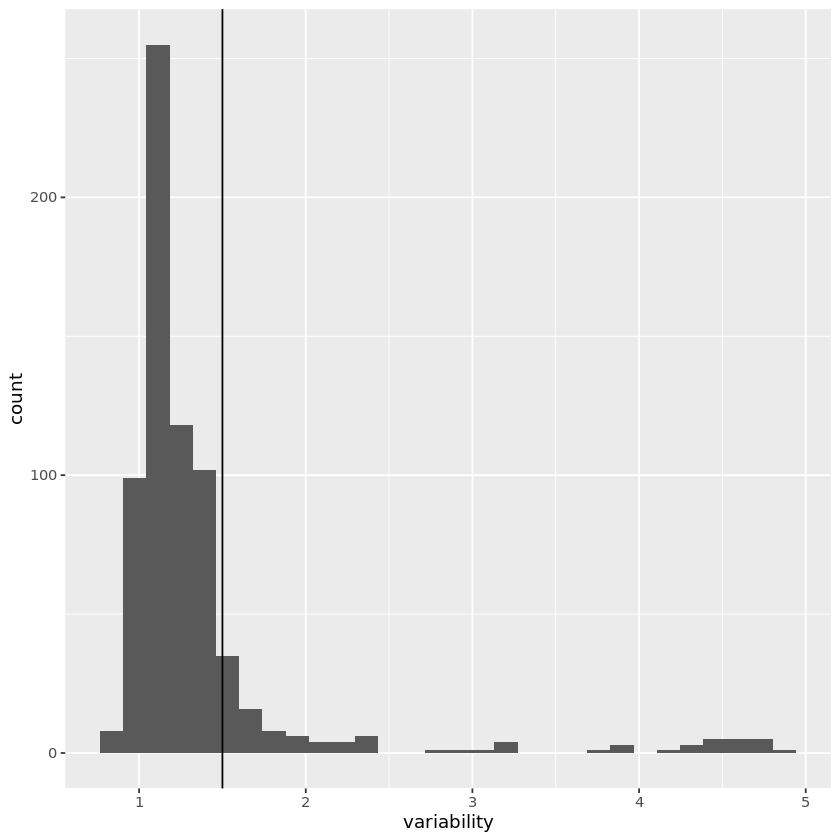

In [23]:
# Variability distirbution
ggplot(variability, aes(x=variability)) +
geom_histogram() + geom_vline(xintercept = 1.5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


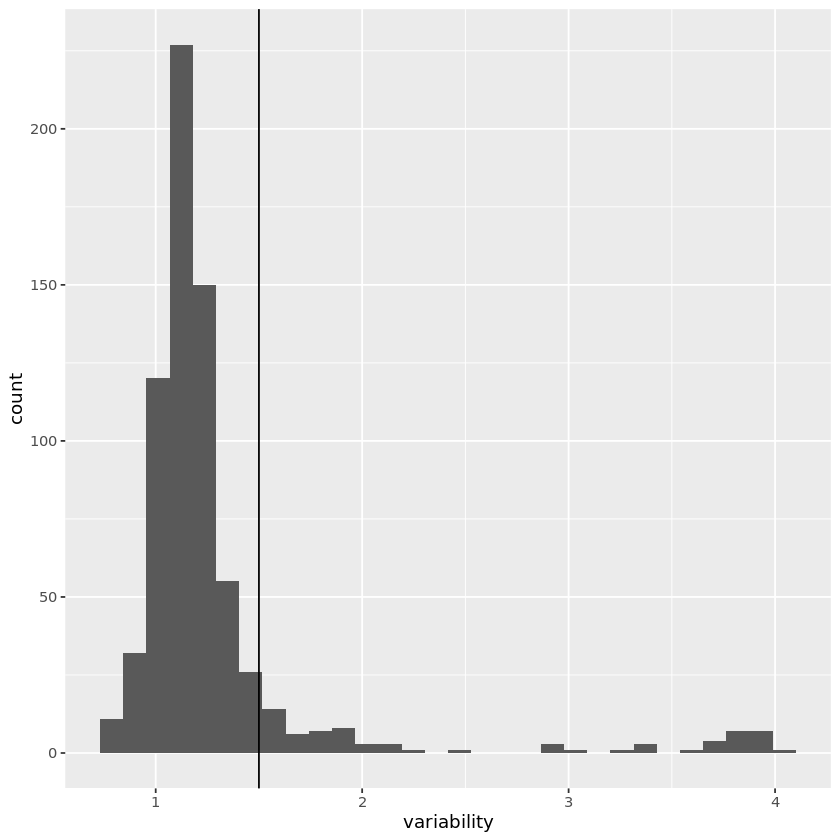

In [42]:
# Variability distirbution
ggplot(variability, aes(x=variability)) +
geom_histogram() + geom_vline(xintercept = 1.5)

# Run on HPAP

In [1]:
suppressMessages(library(chromVAR))
suppressMessages(library(motifmatchr))
suppressMessages(library(SummarizedExperiment))

library(Signac)
library(Seurat)
library(JASPAR2020)
library(TFBSTools)
library(BSgenome.Hsapiens.UCSC.hg38)
library(patchwork)
library(readr)
library(stringr)
library(dplyr)
set.seed(1234)
library(ggplot2)

library(Matrix)
library(BiocParallel)
register(MulticoreParam(8))

#### Send to channel code
library(parallel)
library(qvalue)

Signac built for for SeuratObject v4 was just loaded with SeuratObject
v5; disabling v5 assays and validation routines, and ensuring assays
work in strict v3/v4 compatibility mode

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘sp’


The following object is masked from ‘package:IRanges’:

    %over%



Attaching package: ‘SeuratObject’


The following object is masked from ‘package:SummarizedExperiment’:

    Assays


The following object is masked from ‘package:GenomicRanges’:

    intersect


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following object is masked from ‘package:IRanges’:

    intersect


The following object is masked from ‘package:S4Vectors’:

    intersect


The following object is masked from ‘package:BiocGenerics’:

    intersect


The following object is masked from ‘package:base’:

    intersect



Attaching package: ‘Seurat’


The following object is masked from ‘package:SummarizedE

In [2]:
motif.ix <- readRDS('/nfs/lab/welison/islet_multiome/intermediates/chromVAR/240322_WE_MotifMatches_Union_Peaks.RDS')

In [6]:
head(rownames(motif.ix))

[1] "chr1-1000073-1000373"     "chr1-100036794-100037094"
[3] "chr1-100037929-100038229" "chr1-100046138-100046438"
[5] "chr1-100046907-100047207" "chr1-100050188-100050403"

In [10]:
list.files('/nfs/lab/projects/multiomic_islet/outputs/multiome/generate_peaks_matrix/240403_HPAP_ND_union_peaks/lfms/')

[1] "HPAP-035" "HPAP-036" "HPAP-039" "HPAP-040" "HPAP-044" "HPAP-045"
 [7] "HPAP-047" "HPAP-049" "HPAP-050" "HPAP-052" "HPAP-053" "HPAP-054"
[13] "HPAP-056" "HPAP-059" "HPAP-063" "HPAP-067" "HPAP-069" "HPAP-072"
[19] "HPAP-075" "HPAP-077" "HPAP-080" "HPAP-092" "HPAP-099" "HPAP-101"
[25] "HPAP-103" "HPAP-104" "HPAP-105"

In [20]:
#for (samp in samples[1]) {

#annotation <- GetGRangesFromEnsDb(ensdb = EnsDb.Hsapiens.v86)
#seqlevelsStyle(annotation) <- 'UCSC'

lfms <- list()

hvws <- rownames(motif.ix)

window_dir <- '/nfs/lab/projects/multiomic_islet/outputs/multiome/generate_peaks_matrix/240403_HPAP_ND_union_peaks/lfms/'

samples <- list.files(window_dir)

for (samp in samples) {
    print(paste0(which(samples %in% samp) * 100 /length(samples),"% - ", samp))

    #Read in the atac lfm matrix
    lfm_in <- read.table(paste0(window_dir, samp,'/',samp,'.long_fmt_mtx.txt.gz'), col.names=c('Window','Barcode','Count'))
    lfm_in$Window <- as.factor(lfm_in$Window)
    lfm_in$Barcode <- as.factor(lfm_in$Barcode)
    
    lfm_in_filt <- filter(lfm_in, Window %in% hvws)

    print(dim(lfm_in_filt))

    mis_windows <- hvws[!hvws %in% levels(lfm_in_filt$Window)]
    length(mis_windows)

    #make sure there are missing_windows
    if (length(mis_windows) > 0){
        print('Adding missing windows')
        #create a new long format matrix (sm) with the missing windows added as 0 counts
        filler_bc <- as.character(lfm_in_filt$Barcode[[1]])
        print(paste("Using filler BC:",filler_bc,sep=" "))
        new_rows <- cbind(as.data.frame(mis_windows),
                          as.data.frame(rep(filler_bc),length(mis_windows)),
                          as.data.frame(rep(0,length(mis_windows))))
        colnames(new_rows) <- c("Window","Barcode","Count")
        lfm_in_fix <- rbind(lfm_in_filt,new_rows)
    #if there aren't, set lfm to df
    } else {
        print('No windows were missing')
        lfm_in_fix <- lfm_in_filt
    }

    print(dim(lfm_in_fix))
    
    lfm_in_fix$Window <- factor(lfm_in_fix$Window, levels=hvws)
    lfm_in_sort <- lfm_in_fix[order(lfm_in_fix$Window),]
    lfm_in_sort$Barcode <- as.factor(lfm_in_sort$Barcode)

    lfms[[samp]] <- with(lfm_in_sort, sparseMatrix(i=as.numeric(Window), j=as.numeric(Barcode), x=Count, dimnames=list(levels(Window), levels(Barcode))))

    print(dim(lfms[[samp]]))
    
    gc()
}

gc()

summary(lfms)

[1] "3.7037037037037% - HPAP-035"
[1] 40967967        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-035_AAACTCGCAACTAGAA"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 40968162        3
[1] 291821   2849
[1] "7.40740740740741% - HPAP-036"
[1] 41443867        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-036_AAACGAACATCCGTAA"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 41444608        3
[1] 291821   5780
[1] "11.1111111111111% - HPAP-039"
[1] 23540054        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-039_AAACGAAAGTCCTTCC"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 23541192        3
[1] 291821   3029
[1] "14.8148148148148% - HPAP-040"
[1] 50088003        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-040_AAACGAAAGGATGTCG"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 50088492        3
[1] 291821   3097
[1] "18.5185185185185% - HPAP-044"
[1] 4538632       3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-044_AAACTCGTCGTGGTAT"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 4565483       3
[1] 291821    817
[1] "22.2222222222222% - HPAP-045"
[1] 16598129        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-045_AAATGCCCAGTTCGGC"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 16603914        3
[1] 291821   2085
[1] "25.9259259259259% - HPAP-047"
[1] 4945528       3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-047_AACAGTCGTGGAAGCT"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 4967643       3
[1] 291821    913
[1] "29.6296296296296% - HPAP-049"
[1] 40731671        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-049_AAACGAAGTAGCCATT"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 40732409        3
[1] 291821   3148
[1] "33.3333333333333% - HPAP-050"
[1] 18478898        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-050_AAACGAAAGGAGACTC"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 18482540        3
[1] 291821   1213
[1] "37.037037037037% - HPAP-052"
[1] 20643630        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-052_AAACGAAGTATCACAC"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 20645754        3
[1] 291821   1248
[1] "40.7407407407407% - HPAP-053"
[1] 12685480        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-053_AAATGCCAGTCATCTG"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 12693190        3
[1] 291821   1548
[1] "44.4444444444444% - HPAP-054"
[1] 18608309        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-054_AAACTCGAGTCGCCTG"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 18610442        3
[1] 291821   3196
[1] "48.1481481481481% - HPAP-056"
[1] 16757756        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-056_AAACTGCGTAGGTAAT"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 16762213        3
[1] 291821   2309
[1] "51.8518518518519% - HPAP-059"
[1] 12047306        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-059_AAACGAAGTCATGAGG"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 12051175        3
[1] 291821   1567
[1] "55.5555555555556% - HPAP-063"
[1] 10411330        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-063_AAATGCCAGTGAGTTA"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 10419814        3
[1] 291821   1116
[1] "59.2592592592593% - HPAP-067"
[1] 9489082       3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-067_AAATGCCTCCCAGCGA"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 9502407       3
[1] 291821   1812
[1] "62.962962962963% - HPAP-069"
[1] 14648736        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-069_AAACGAAAGACCATAA"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 14653715        3
[1] 291821   2247
[1] "66.6666666666667% - HPAP-072"
[1] 28673649        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-072_AAACGAAAGCTAGTTC"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 28674058        3
[1] 291821   2263
[1] "70.3703703703704% - HPAP-075"
[1] 23600690        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-075_AAACGAAGTGCATCAT"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 23602003        3
[1] 291821   1817
[1] "74.0740740740741% - HPAP-077"
[1] 34080906        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-077_AAACGAATCGGTCTCT"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 34082497        3
[1] 291821   2316
[1] "77.7777777777778% - HPAP-080"
[1] 27028918        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-080_AAACTCGAGAGCCTGA"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 27031555        3
[1] 291821   2952
[1] "81.4814814814815% - HPAP-092"
[1] 44826836        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-092_AAACTCGTCTATATCC"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 44827697        3
[1] 291821   3811
[1] "85.1851851851852% - HPAP-099"
[1] 37729254        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-099_AAACGAAAGTACAGTA"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 37731109        3
[1] 291821   5149
[1] "88.8888888888889% - HPAP-101"
[1] 26963606        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-101_AAACGAAAGCTCCATA"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 26967388        3
[1] 291821   3489
[1] "92.5925925925926% - HPAP-103"
[1] 32842019        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-103_AAACTGCTCGTGGTAT"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 32843191        3
[1] 291821   4114
[1] "96.2962962962963% - HPAP-104"
[1] 40914736        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-104_AAACTCGGTCCAAGAG"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 40915103        3
[1] 291821   3668
[1] "100% - HPAP-105"
[1] 55009268        3
[1] "Adding missing windows"
[1] "Using filler BC: HPAP-105_AAACGAACAGAGAGAA"


Warning message in as.data.frame.vector(x, ..., nm = nm):
“'row.names' is not a character vector of length 1 -- omitting it. Will be an error!”


[1] 55009872        3
[1] 291821   3861


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,12003752,641.1,17818672,951.7,17818672,951.7
Vcells,1519702245,11594.5,2621003771,19996.7,3034568608,23152.0


         Length     Class     Mode
HPAP-035  831398029 dgCMatrix S4  
HPAP-036 1686725380 dgCMatrix S4  
HPAP-039  883925809 dgCMatrix S4  
HPAP-040  903769637 dgCMatrix S4  
HPAP-044  238417757 dgCMatrix S4  
HPAP-045  608446785 dgCMatrix S4  
HPAP-047  266432573 dgCMatrix S4  
HPAP-049  918652508 dgCMatrix S4  
HPAP-050  353978873 dgCMatrix S4  
HPAP-052  364192608 dgCMatrix S4  
HPAP-053  451738908 dgCMatrix S4  
HPAP-054  932659916 dgCMatrix S4  
HPAP-056  673814689 dgCMatrix S4  
HPAP-059  457283507 dgCMatrix S4  
HPAP-063  325672236 dgCMatrix S4  
HPAP-067  528779652 dgCMatrix S4  
HPAP-069  655721787 dgCMatrix S4  
HPAP-072  660390923 dgCMatrix S4  
HPAP-075  530238757 dgCMatrix S4  
HPAP-077  675857436 dgCMatrix S4  
HPAP-080  861455592 dgCMatrix S4  
HPAP-092 1112129831 dgCMatrix S4  
HPAP-099 1502586329 dgCMatrix S4  
HPAP-101 1018163469 dgCMatrix S4  
HPAP-103 1200551594 dgCMatrix S4  
HPAP-104 1070399428 dgCMatrix S4  
HPAP-105 1126720881 dgCMatrix S4  

In [28]:
lfm <- do.call(cbind, lfms)

dim(lfm)
head(lfm)

[1] 291821  71414

  [[ suppressing 34 column names ‘HPAP-035_AAACGAAAGAGAGTTT’, ‘HPAP-035_AAACGAAAGGGTAGTC’, ‘HPAP-035_AAACGAACATTTGGCA’ ... ]]



6 x 71414 sparse Matrix of class "dgCMatrix"
                                                                              
chr1-1000073-1000373     . . . . . . . . . 5 . . . . 2 . . . . . . . . . . 2 .
chr1-100036794-100037094 . . . . . . 2 2 . 2 . . . . . . . . . . . . . . . . .
chr1-100037929-100038229 . . 3 3 5 2 . . . . . . . . . . 3 . 4 . . . . . . . .
chr1-100046138-100046438 . . . . . . . . . . . . . . . . . . . . . . . . . . .
chr1-100046907-100047207 . . . . . . . . . . . . . . . . . . . 2 . . . . . . .
chr1-100050188-100050403 . . . . . . . . . . . . . . . . . . . . . . . . 2 . .
                                             
chr1-1000073-1000373     . . . . . . . ......
chr1-100036794-100037094 . . . . . . . ......
chr1-100037929-100038229 . . . . 2 2 2 ......
chr1-100046138-100046438 . . . . . . . ......
chr1-100046907-100047207 . . . . . . . ......
chr1-100050188-100050403 . . . . . . . ......

 .....suppressing 71380 columns in show(); maybe adjust options(max.print=, wid

In [41]:
names(which(rowSums(lfm) != 0))

[1] "chr22-16354601-16354870" "chrM-11303-11603"       
[3] "chrM-16221-16521"        "chrM-31-331"            
[5] "chrM-3345-3645"          "chrM-6181-6481"         
[7] "chrM-7955-8255"          "chrM-9124-9424"         
[9] "chrY-56685464-56685764"

In [ ]:
motif.ix()

In [29]:
#Prep inputs for SummarizedExperiment

#Extract matrix from Seurat object
sc.data <- lfm
sc.data.stored <- sc.data

# Extract peak locations and reformat into GRanges object
bed = str_split_fixed(rownames(sc.data), "\\-", 3) #This may need to be modified depending on your peak naming convention

gr= GRanges(seqnames = bed[,1], ranges = IRanges(start = as.numeric(bed[,2]), end = as.numeric(bed[,3])))

In [30]:
#Use the matrix and GRanges to make a SummarizedExperiment to put into chromvar and add metadata

fragment.counts <- SummarizedExperiment(assays=list(counts=sc.data), rowRanges=gr)
fragment.counts.stored <- fragment.counts

fragment.counts <- addGCBias(fragment.counts, genome=BSgenome.Hsapiens.UCSC.hg38)
fragment.counts

class: RangedSummarizedExperiment 
dim: 291821 71414 
metadata(0):
assays(1): counts
rownames(291821): chr1-1000073-1000373 chr1-100036794-100037094 ...
  chrY-9652738-9653038 chrY-9812080-9812380
rowData names(1): bias
colnames(71414): HPAP-035_AAACGAAAGAGAGTTT HPAP-035_AAACGAAAGGGTAGTC
  ... HPAP-105_TTTGTGTGTACCAAGG HPAP-105_TTTGTGTGTTAGAGAT
colData names(0):

In [44]:
fragment.counts.sub <- fragment.counts[names(which(rowSums(lfm) != 0)),]
fragment.counts.sub

class: RangedSummarizedExperiment 
dim: 291812 71414 
metadata(0):
assays(1): counts
rownames(291812): chr1-1000073-1000373 chr1-100036794-100037094 ...
  chrY-9652738-9653038 chrY-9812080-9812380
rowData names(1): bias
colnames(71414): HPAP-035_AAACGAAAGAGAGTTT HPAP-035_AAACGAAAGGGTAGTC
  ... HPAP-105_TTTGTGTGTACCAAGG HPAP-105_TTTGTGTGTTAGAGAT
colData names(0):

In [45]:
motif.ix.sub <- motif.ix[names(which(rowSums(lfm) != 0)),]
motif.ix.sub

class: RangedSummarizedExperiment 
dim: 291812 692 
metadata(0):
assays(1): motifMatches
rownames(291812): chr1-1000073-1000373 chr1-100036794-100037094 ...
  chrY-9652738-9653038 chrY-9812080-9812380
rowData names(1): bias
colnames(692): MA0030.1_FOXF2 MA0031.1_FOXD1 ... MA1633.2_BACH1
  MA0597.2_THAP1
colData names(1): name

In [46]:
# Run chromVAR
dev <- computeDeviations(object=fragment.counts.sub, annotations=motif.ix.sub)#, expectation=expected)#
head(dev)

class: chromVARDeviations 
dim: 6 71414 
metadata(0):
assays(2): deviations z
rownames(6): MA0030.1_FOXF2 MA0031.1_FOXD1 ... MA0066.1_PPARG
  MA0069.1_PAX6
rowData names(3): name fractionMatches fractionBackgroundOverlap
colnames(71414): HPAP-035_AAACGAAAGAGAGTTT HPAP-035_AAACGAAAGGGTAGTC
  ... HPAP-105_TTTGTGTGTACCAAGG HPAP-105_TTTGTGTGTTAGAGAT
colData names(0):

In [47]:
saveRDS(dev, "/nfs/lab/welison/islet_multiome/intermediates/chromVAR/240322_WE_ChromVAR_Object_Union_Peaks_HPAP.RDS")

# Collect details for downstream analysis

In [48]:
# Reload chromVAR object and motifs if picking up again
dev <- readRDS("/nfs/lab/welison/islet_multiome/intermediates/chromVAR/240322_WE_ChromVAR_Object_Union_Peaks_HPAP.RDS")
jaspar.motifs <- readRDS(file ='/nfs/lab/welison/multiome/chromvar/jaspar_2022_object.Rdata')

In [49]:
dev
jaspar.motifs

class: chromVARDeviations 
dim: 692 71414 
metadata(0):
assays(2): deviations z
rownames(692): MA0030.1_FOXF2 MA0031.1_FOXD1 ... MA1633.2_BACH1
  MA0597.2_THAP1
rowData names(3): name fractionMatches fractionBackgroundOverlap
colnames(71414): HPAP-035_AAACGAAAGAGAGTTT HPAP-035_AAACGAAAGGGTAGTC
  ... HPAP-105_TTTGTGTGTACCAAGG HPAP-105_TTTGTGTGTTAGAGAT
colData names(0):

PFMatrixList of length 692
names(692): MA0030.1_FOXF2 MA0031.1_FOXD1 ... MA1633.2_BACH1 MA0597.2_THAP1

In [50]:
#This is a cell by motif deviation score (aka accessibility) matrix
devtab = deviationScores(dev)
head(devtab)

,HPAP-035_AAACGAAAGAGAGTTT,HPAP-035_AAACGAAAGGGTAGTC,HPAP-035_AAACGAACATTTGGCA,HPAP-035_AAACGAAGTAGAAAGG,HPAP-035_AAACGAAGTGTTAGAA,HPAP-035_AAACGAATCCATTGAG,HPAP-035_AAACGAATCGAGGTCC,HPAP-035_AAACGAATCTCTATCA,HPAP-035_AAACTCGAGACGTCAG,HPAP-035_AAACTCGCAACTAGAA,⋯,HPAP-105_TTTGGTTCAGAGAGAA,HPAP-105_TTTGGTTCATTCTCGC,HPAP-105_TTTGGTTGTAGAACGC,HPAP-105_TTTGGTTGTTCTTTCA,HPAP-105_TTTGGTTTCGTGTGCG,HPAP-105_TTTGTGTAGACACTTC,HPAP-105_TTTGTGTAGGCTTTAC,HPAP-105_TTTGTGTCAGTAAGAT,HPAP-105_TTTGTGTGTACCAAGG,HPAP-105_TTTGTGTGTTAGAGAT
MA0030.1_FOXF2,0.4110235,-2.2466023,0.4994183,-1.5292301,-1.7146833,-0.6919612,-2.9399106,-0.7975196,0.5105827,-3.5968995,⋯,2.00580990,1.2681924,1.8960060,1.82322358,1.9646631,1.7403391,-0.397416182,3.1626487,1.8714928,0.8987203
MA0031.1_FOXD1,0.6215934,-2.1892645,-0.8988423,-1.5389502,-0.8112179,-0.5220922,-2.4825019,-2.0059123,1.5878922,-3.6713462,⋯,0.08752599,0.3260774,-0.3708923,0.89398947,2.4657506,1.2938397,0.169278858,0.9728386,0.9554917,-1.2175132
MA0051.1_IRF2,0.1558243,1.5312479,0.1209592,-2.0540741,-0.0282015,-0.4244030,0.1078591,1.6894956,1.2432349,0.8918917,⋯,-3.16689974,0.1715135,-0.2727399,0.02613013,-1.6138135,-0.5546000,1.095427915,-0.3268551,0.2292729,1.4667138
MA0059.1_MAX::MYC,-1.6449995,-2.8604461,2.1255383,-1.1170332,-1.8716565,1.6542892,-1.2050095,-1.8158865,0.0583148,-3.0814519,⋯,0.17282733,-1.1952290,0.5537114,1.62260564,1.8295354,-0.2482226,0.525653840,0.5281819,-0.7283575,1.6599786
MA0066.1_PPARG,-0.6838186,0.4206531,0.3736456,0.6541631,0.1454583,-0.2204830,-0.9553245,2.0338884,1.0870040,1.0721670,⋯,1.79897242,0.6956100,-1.8101150,-0.97424185,0.2384596,0.2941571,-2.024672396,-1.0917269,-0.9670213,0.6722861
MA0069.1_PAX6,-1.0757529,-2.1265548,-0.7889080,-0.1372047,-4.0116725,0.4760245,-1.3316233,-1.8570831,0.3816542,-5.9050210,⋯,-0.71851202,-0.2581124,-0.3231095,1.17005522,0.5514249,0.1453184,-0.007414741,0.1666301,0.9801364,-0.0214014


In [51]:
# Variation of accessibiility across deviation scores, basically the standard errror. Null is about 1
variability <- computeVariability(dev)
head(variability)

,name,variability,bootstrap_lower_bound,bootstrap_upper_bound,p_value,p_value_adj
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
MA0030.1_FOXF2,FOXF2,1.693341,1.682550,1.703470,0,0
MA0031.1_FOXD1,FOXD1,1.774747,1.762893,1.786564,0,0
MA0051.1_IRF2,IRF2,1.591066,1.578550,1.602822,0,0
MA0059.1_MAX::MYC,MAX::MYC,1.194091,1.188227,1.200607,0,0
MA0066.1_PPARG,PPARG,1.194302,1.187975,1.201412,0,0
MA0069.1_PAX6,PAX6,1.490371,1.482693,1.498685,0,0


In [52]:
motifdata = cbind(sapply(jaspar.motifs, function(x) unlist(x@name)),sapply(jaspar.motifs, function(x) unlist(x@matrixClass )))                                                  
motifdata             #  sapply(pfm, function(x) x@tags$symbol )  ,     sapply(pfm, function(x) x@tags$family ))

MA0030.1_FOXF2,FOXF2,Fork head/winged helix factors
MA0031.1_FOXD1,FOXD1,Fork head/winged helix factors
MA0051.1_IRF2,IRF2,Tryptophan cluster factors
MA0059.1_MAX::MYC,MAX::MYC,Basic helix-loop-helix factors (bHLH)
MA0066.1_PPARG,PPARG,Nuclear receptors with C4 zinc fingers
MA0069.1_PAX6,PAX6,Paired box factors
MA0070.1_PBX1,PBX1,Homeo domain factors
MA0071.1_RORA,RORA,Nuclear receptors with C4 zinc fingers
MA0072.1_RORA,RORA,Nuclear receptors with C4 zinc fingers
MA0073.1_RREB1,RREB1,C2H2 zinc finger factors
MA0074.1_RXRA::VDR,RXRA::VDR,Nuclear receptors with C4 zinc fingers


In [53]:
output_dir <- '/nfs/lab/welison/islet_multiome/intermediates/chromVAR/'
#dir.create(output_dir)

In [54]:
#Save devscores, motifdata, and info
write.table(devtab, file=paste0(output_dir,'devscores_Union_Peaks_HPAP.txt'),quote = FALSE, col.names = TRUE, row.names = TRUE)
write.table(motifdata, file=paste0(output_dir,'motifdata_Union_Peaks_HPAP.txt'),quote = FALSE, col.names = FALSE,sep='\t')
write.table(variability, file=paste0(output_dir,'variability_Union_Peaks_HPAP.txt'),quote = FALSE, col.names = TRUE, row.names = TRUE, sep='\t')

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


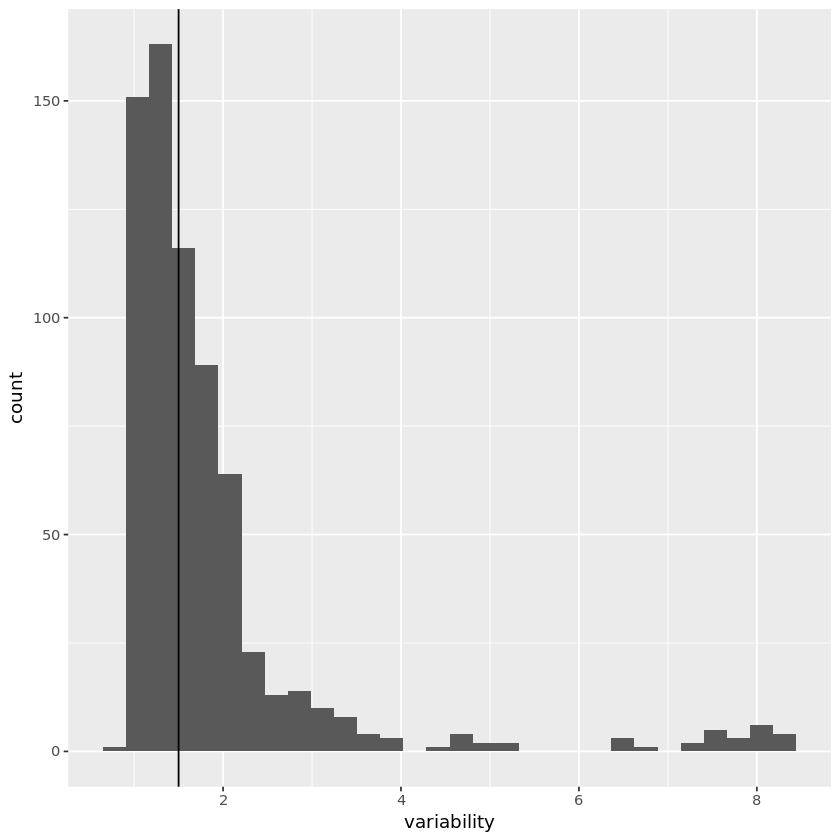

In [55]:
# Variability distirbution
ggplot(variability, aes(x=variability)) +
geom_histogram() + geom_vline(xintercept = 1.5)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


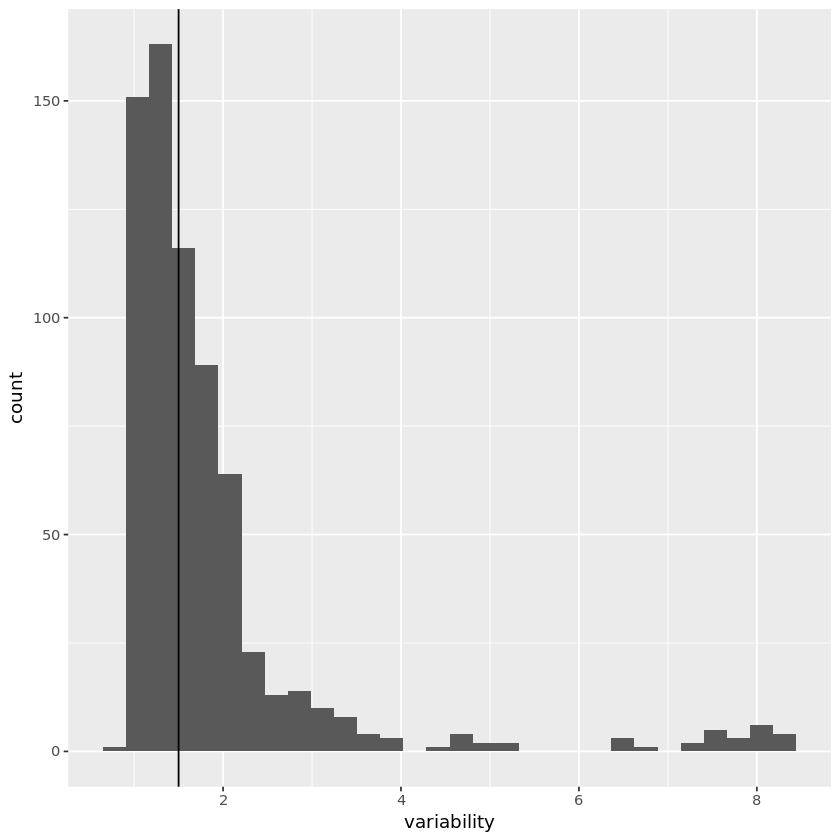

In [56]:
# Variability distirbution
ggplot(variability, aes(x=variability)) +
geom_histogram() + geom_vline(xintercept = 1.5)